In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys
import seaborn as sns

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

# GM

In [3]:
#you can also query like this
blaze_gm_data = pd.read_sql_query("""
with base as 
(
   select
      *,
      last_day(week_start) year_month,
      retail_value / quantity_sold per_unit_price,
      cogs / quantity_sold per_unit_cost,
      sales.retail_value - sales.total_discount + sales.total_tax sales_post_tax_post_discount,
      sales.retail_value - sales.total_discount sales_pre_tax_post_discount,
      sales.retail_value sales_pre_tax_pre_discount,
   from
      blaze_data.sales sales
      -- EXCLUDE SAMPLES,DISPLAY,PROMO and test
   where
      lower(product_category) not like '%sample%' 
      and lower(product_category) not like '%display%' 
      and lower(product_category) not like '%promo%' 
      and lower(product_category) not like '%test%'
)
,
monthly_location_rev_and_cogs as 
(
   select
      year_month,
      shopid,
      companyid,
      sum(sales_post_tax_post_discount) rev_post_tax_post_discount,
      sum(sales_pre_tax_post_discount) rev_pre_tax_post_discount,
      sum(sales_pre_tax_pre_discount) rev_pre_tax_pre_discount,
      sum(cogs) cogs 
   from
      base
      -- EXCLUDE low COGS items
   where
      cogs > 1 
      -- EXCLUDE high cost, high price items
      and per_unit_price <= 500 
      and per_unit_cost <= 500 
   group by
      2,
      3,
      1 
   order by
      2,
      3,
      1 
)
,
monthly_location_rev_and_cogs_and_profit as 
(
   select
      year_month,
      shopid,
      companyid,
      -- rev and cogs
      rev_post_tax_post_discount,
      rev_pre_tax_post_discount,
      rev_pre_tax_pre_discount,
      cogs,
      -- profit
      rev_post_tax_post_discount - cogs profit_post_tax_post_discount,
      rev_pre_tax_post_discount - cogs profit_pre_tax_post_discount,
      rev_pre_tax_pre_discount - cogs profit_pre_tax_pre_discount,
   from
      monthly_location_rev_and_cogs 
)
,
monthly_location_rev_and_cogs_and_profit_and_margin as 
(
   select
      year_month,
      shopid,
      companyid,
      -- rev and cogs
      rev_post_tax_post_discount,
      rev_pre_tax_post_discount,
      rev_pre_tax_pre_discount,
      cogs,
      -- profit
      profit_post_tax_post_discount,
      profit_pre_tax_post_discount,
      profit_pre_tax_pre_discount,
      -- margin
      profit_post_tax_post_discount / nullif(rev_post_tax_post_discount, 0) margin_post_tax_post_discount,
      profit_pre_tax_post_discount / nullif(rev_pre_tax_post_discount, 0) margin_pre_tax_post_discount,
      profit_pre_tax_pre_discount / nullif(rev_pre_tax_pre_discount, 0) margin_pre_tax_pre_discount 
   from
      monthly_location_rev_and_cogs_and_profit 
)
,
monthly_gm_analysis as 
(
   select
      year_month,
      shopid,
      companyid,
      -- CHOOSE TO USE PRE TAX POST DISCOUNT
      rev_pre_tax_post_discount,
      lag(rev_pre_tax_post_discount) over (partition by shopid order by year_month) lag_rev_pre_tax_post_discount,
      cogs,
      profit_pre_tax_post_discount,
      margin_pre_tax_post_discount,
      count(distinct year_month) over (partition by shopid ) month_available,
      sum(cogs) over (partition by shopid order by year_month rows between 2 preceding and current row ) sum_cogs_3m,
      avg(margin_pre_tax_post_discount) over (partition by shopid order by year_month rows between 2 preceding and current row ) avg_margin_3m,
      avg(margin_pre_tax_post_discount) over (partition by shopid order by year_month rows between 5 preceding and current row ) avg_margin_6m,
      avg(margin_pre_tax_post_discount) over (partition by shopid order by year_month ) avg_margin_all 
   from
      monthly_location_rev_and_cogs_and_profit_and_margin 
)
select
   *,
   (
      rev_pre_tax_post_discount - lag_rev_pre_tax_post_discount
   )
   / nullif(lag_rev_pre_tax_post_discount, 0) rev_change 
from
   monthly_gm_analysis
   where shopid not in ("5e50449d6c0a910843356fa3",
                        "5e666af1aa809b085a98a646",
                        "56cf846ee38179985229e59e",
                        "5e6d0948b987950831b5092c",
                        "5ab806d6c182bb072e0b0e01",
                        "617b7da0e5cb65322b32781a",
                        "56cf84e4e38179985229e59f",
                        "5ee7c6a938fa9a08c8b7939c",
                        "5eebecd661ea0b08cdbcc386",
                        "56cf855ce38179985229e5a0",
                        "5ef12ad7bb5e7a08c5b3f4f3",
                        "5f1108355ae12008f4fef76e",
                        "5f123a5d12497908d2888dde",
                        "5f2309d579373608c93e6742",
                        "5f341ed02fdd5608e0821b45",
                        "5f8870200260fe08fe708db5",
                        "5f8870200260fe08fe708db6",
                        "5fac6a0b0643cc08efd1d327",
                        "56cf855ce38179985229e5a1",
                        "5d238c1955be2e07f5ee66e5",
                        "57b35a5d920f401e40146301",
                        "603d1a9eb9d7dc08cca27203",
                        "603d1a9eb9d7dc08cca27204",
                        "6046544f61e17808cff96fdb",
                        "6046544f61e17808cff96fdc",
                        "57b35aa8920f401e40146334",
                        "57b6b145920f4045cbe5fe81",
                        "6059219abe32aa08fa3a11dc",
                        "57b6b36a920f4046337f2618",
                        "58a7433f819d9e6ebd427617",
                        "60c0ffd6331cab296f02f49a",
                        "610c0a0d381ba0747c981ce9",
                        "611c0c98127cdd740cff94db",
                        "5a43f72b819d9e3ef9373675",
                        "611c0cc403d2e97dc2c159b0",
                        "5e6d0ac5b987950831b513e3",
                        "5a4563f1819d9e4ae6207e06",
                        "611c0ce7649819050ed4906b",
                        "611c0d02f572ec7882d64eea",
                        "611c0d26d5f1e86542fe3b8b",
                        "61672305b5e382719c7e4c2a",
                        "616dee0e4497e822dae13b21",
                        "616e5b13dd10fe4d3f34fd05",
                        "616e5b13dd10fe4d3f34fd06",
                        "619834e921c8017e23135674",
                        "5ab2d1a5819d9e21137cec3c",
                        "61bb746b82fddc50e058d711",
                        "61c3be757511d81170a29d51",
                        "61d49080eec1b51a3e33dc39",
                        "61d8912bdd71d40c2b68c5b3",
                        "61ba4efb9536472be6a8baa9",
                        "61d895fb3efbfb6da5210ae3",
                        "61d8aaf527205210191d7a1e",
                        "61e72d51073c4a79cfeccb62",
                        "61fdab9eae59d05c49422c3a",
                        "6202bd1c15425361f688aabf",
                        "6202bd1c15425361f688aac0",
                        "5b9f8e1db93307080d35b85f",
                        "5c2c250eabe12808989ac2f7",
                        "58be5603c182bb1f9bcd2ad5",
                        "5c8be64665a6a40808118621",
                        "606761051436a608e166db19",
                        "5ce2eb562d4dcf07fb7d0c5f",
                        "6176fa9eda707b1faba5f717",
                        "5b517867485da70830fcc04e",
                        "5b9f841a17b6e00812fe71f3",
                        "5da023586d8ce1082b9c91bd",
                        "5bbce3db420c21083300e410",
                        "5d238c1955be2e07f5ee66e4",
                        "5b209459062bd807b142a1f6",
                        "5cb1a5839fbb5f0818f6de55",
                        "5cda1adb183d6a0801347027",
                        "5be3903b79015e083194aa70",
                        "5d1ba174cdbd6d0803c99cfd",
                        "5a8a6eb8819d9e78641ab6ec",
                        "5db863825a04a2083b464083",
                        "5d8a7fb3a3274308311743d5",
                        "5d8a7fb3a3274308311743d6",
                        "5d9e425d52d15b0824a8a5d5",
                        "5dd6da52ce4015084c72e8db",
                        "5e07f51837cdd7082662f3c6",
                        "5e4d849981e3cd08326b6c14",
                        "5dfd2308fa462a086a8bfab8",
                        "5e0ee2710a7b7008346b06b4",
                        "5e4d849981e3cd08326b6c15",
                        "5dfd2308fa462a086a8bfab9",
                        "5e6d0adc12f2e208728f9369",
                        "5e6d0948b987950831b5092b",
                        "5ed589d96c0bf408dcc92d97",
                        "5eebecd761ea0b08cdbcc387",
                        "5ef12ad7bb5e7a08c5b3f4f2",
                        "5f63afd430bd7208ce1ab304",
                        "5f63afd430bd7208ce1ab305",
                        "5bf5ce54062bd807e436b473",
                        "5fac691a715f3808cd0aa82d",
                        "5d9d7fc27e2e46081e7e69f3",
                        "6034287d52503608c0b3ca48",
                        "5dfd40ea521ea90860c91848",
                        "6034287d52503608c0b3ca49",
                        "60636227ec491108d1c970d5",
                        "5a9a2274c182bb4ec00a72ca",
                        "60aea3bb1940943cecec2dbf",
                        "60a2f1610f75543c8e7dde50",
                        "5eb98f2d649a6508f87a6436",
                        "5e62a68447d90a086b8231c0",
                        "5e62a68447d90a086b8231c1",
                        "615b634cac08aa0a794158c4",
                        "60a2db8d0f75543c8e7d513b",
                        "60a2db8d0f75543c8e7d513c",
                        "60a4051e67406e7edad8ab88",
                        "60c0ff66082dcc61e42ad4a6",
                        "60c0ff66082dcc61e42ad4a7",
                        "6046c57057abe808d1f260fd",
                        "60636227ec491108d1c970d4",
                        "610abcaec3d09859f9b630d1",
                        "606cfaadba253e08c4189a63",
                        "607a321441cfa308f6e65b58",
                        "6197e31b21c8017e2310c10e",
                        "611d457db7c6f80914292394",
                        "610c0a0d381ba0747c981cea",
                        "610abcaec3d09859f9b630d2",
                        "611c0cb3a29e0f598f108a60",
                        "5fff453a81a63608d3a1a5b7",
                        "615237cc0937e52684b6c134",
                        "620b59c97852ca7a7dcc6f05",
                        "6196aa4deb62c87eba4014ad",
                        "619816781f88a1280f8a0c28",
                        "61d7b217a42c2f124d9b76b1",
                        "61cf4b452bc6657512b92d2a",
                        "61ebb060b04dc7510465f774",
                        "61eedaa0b882812f2f46a23d",
                        "61eedade6716dd2a2e0cfce5",
                        "5e6d0ae6e4a25a0834047467",
                        "5dc3315fe0faca07c6dfe849",
                        "5f7e17594445b008d2f63ebd",
                        "5f7f63053dbcad08cc9edbfb",
                        "5fff453a81a63608d3a1a5b8",
                        "603d5425a9ca7208f886d156",
                        "60e48dbbd5596d7c8a1d24dc",
                        "611c0d335901162ff90ef4dd",
                        "613f771aa96c863c00c1517d",
                        "6153b70fd343dc6230c4b67d",
                        "61699cdf032e1c1f920ec70f",
                        "61699cdf032e1c1f920ec710",
                        "61a7b4c6c8c7d85ea1846f14",
                        "61c390cfb863cb3baddb70f4",
                        "61d7b252ae999342ac05499e",
                        "61e6f857c5da34762f1c1fb5",
                        "61ebb00a335a531542342a32",
                        "620b59c97852ca7a7dcc6f04",
                        "6226640755810d3311e8ecd0")
""",engine)

In [4]:
#blaze_gm_data['year_month'] = pd.to_datetime(blaze_gm_data['year_month'])

In [5]:
#blaze_gm_data[(blaze_gm_data['year_month'] <= '2021-12-31')]['rev_pre_tax_post_discount'].sum() * (12/5)


In [6]:
#blaze_gm_data[(blaze_gm_data['year_month'] <= '2021-12-31')]['shopid'].nunique()

In [7]:
blaze_gm_data['shopid'].nunique()

335

In [8]:
blaze_gm_data[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2021-08-31,236
2021-09-30,246
2021-10-31,264
2021-11-30,261
2021-12-31,266
2022-01-31,267
2022-02-28,265
2022-03-31,272


In [9]:
blaze_gm_data_long = blaze_gm_data[blaze_gm_data['month_available'] >= 6]

In [85]:
blaze_gm_data_short = blaze_gm_data[blaze_gm_data['month_available']  < 6]

In [90]:
blaze_gm_data_short['shopid'].nunique()

107

In [95]:
blaze_gm_data_short[blaze_gm_data_short['month_available'] == 1]['shopid'].nunique()

32

(array([ 32.,   0.,  24.,   0.,   0.,  60.,   0.,  76.,   0., 120.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

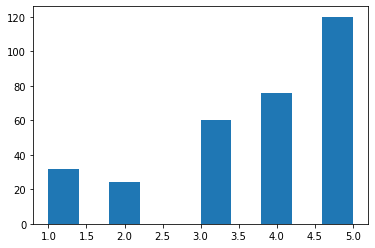

In [89]:
plt.hist(blaze_gm_data_short['month_available'])

In [10]:
blaze_gm_data_long[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2021-08-31,204
2021-09-30,212
2021-10-31,226
2021-11-30,227
2021-12-31,227
2022-01-31,227
2022-02-28,222
2022-03-31,220


In [11]:
blaze_gm_data_long[['year_month','shopid']].groupby(['year_month']).nunique() / blaze_gm_data[['year_month','shopid']].groupby(['year_month']).nunique()


,shopid
year_month,
2021-08-31,0.864407
2021-09-30,0.861789
2021-10-31,0.856061
2021-11-30,0.869732
2021-12-31,0.853383
2022-01-31,0.850187
2022-02-28,0.837736
2022-03-31,0.808824


## MoM margin

In [12]:
# mom margin
gm_distr_mom = blaze_gm_data_long.groupby(['year_month'])['margin_pre_tax_post_discount'].describe().reset_index()
gm_distr_mom.index = pd.to_datetime(gm_distr_mom['year_month'])
gm_distr_mom

,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,
2021-08-31,2021-08-31,204.0,0.513012,0.218525,-1.844289,0.465168,0.524776,0.589914,0.987216
2021-09-30,2021-09-30,212.0,0.503415,0.353105,-4.079118,0.472500,0.532106,0.593041,0.986196
2021-10-31,2021-10-31,226.0,0.515142,0.232775,-2.359420,0.469338,0.527733,0.588102,0.988435
2021-11-30,2021-11-30,227.0,0.525804,0.137461,-0.350991,0.464301,0.527382,0.595820,0.996017
2021-12-31,2021-12-31,227.0,0.530430,0.129925,-0.195993,0.466587,0.528110,0.601962,0.949353
2022-01-31,2022-01-31,227.0,0.535558,0.124973,-0.206441,0.475145,0.537372,0.600279,0.994545
2022-02-28,2022-02-28,222.0,0.509542,0.268731,-2.698762,0.464780,0.539483,0.594311,0.993018
2022-03-31,2022-03-31,220.0,0.527836,0.162369,-1.041996,0.466236,0.544240,0.597757,0.981089


In [13]:
round(gm_distr_mom[['25%','50%','75%']].mean(),2)

25%    0.47
50%    0.53
75%    0.60
dtype: float64

In [14]:
round(blaze_gm_data_long['margin_pre_tax_post_discount'].quantile(0.95),2)

0.7

## 3m

In [15]:
gm_distr_3m = blaze_gm_data_long.groupby(['year_month'])['avg_margin_3m'].describe().reset_index()
gm_distr_3m.index = pd.to_datetime(gm_distr_3m['year_month'])
gm_distr_3m

,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,
2021-08-31,2021-08-31,204.0,0.513012,0.218525,-1.844289,0.465168,0.524776,0.589914,0.987216
2021-09-30,2021-09-30,212.0,0.509274,0.262244,-2.298180,0.473780,0.528687,0.590482,0.986706
2021-10-31,2021-10-31,226.0,0.518097,0.190828,-1.699958,0.469135,0.525162,0.587677,0.987282
2021-11-30,2021-11-30,227.0,0.512946,0.213533,-1.493813,0.468232,0.527176,0.591861,0.990216
2021-12-31,2021-12-31,227.0,0.517676,0.196566,-1.341183,0.467420,0.531932,0.588581,0.971101
2022-01-31,2022-01-31,227.0,0.530630,0.126787,-0.208328,0.465410,0.531304,0.596885,0.973138
2022-02-28,2022-02-28,222.0,0.524131,0.151149,-0.602264,0.462410,0.534833,0.598448,0.972138
2022-03-31,2022-03-31,220.0,0.523930,0.156160,-0.611247,0.461913,0.537323,0.594740,0.989551


In [16]:
round(gm_distr_3m[['25%','50%','75%']].mean(),2)

25%    0.47
50%    0.53
75%    0.59
dtype: float64

In [17]:
round(blaze_gm_data_long['avg_margin_3m'].quantile(0.95),2)

0.69

## 6m

In [18]:
gm_distr_6m = blaze_gm_data_long.groupby(['year_month'])['avg_margin_6m'].describe().reset_index()
gm_distr_6m.index = pd.to_datetime(gm_distr_6m['year_month'])
gm_distr_6m

,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,
2021-08-31,2021-08-31,204.0,0.513012,0.218525,-1.844289,0.465168,0.524776,0.589914,0.987216
2021-09-30,2021-09-30,212.0,0.509274,0.262244,-2.298180,0.473780,0.528687,0.590482,0.986706
2021-10-31,2021-10-31,226.0,0.518097,0.190828,-1.699958,0.469135,0.525162,0.587677,0.987282
2021-11-30,2021-11-30,227.0,0.512006,0.217987,-1.493813,0.470547,0.527781,0.589059,0.989466
2021-12-31,2021-12-31,227.0,0.515876,0.192939,-1.135198,0.470213,0.529259,0.588462,0.977343
2022-01-31,2022-01-31,227.0,0.519657,0.176660,-0.948519,0.468444,0.530984,0.590971,0.980210
2022-02-28,2022-02-28,222.0,0.517446,0.166653,-0.739712,0.463902,0.530045,0.590611,0.981177
2022-03-31,2022-03-31,220.0,0.519798,0.162718,-0.764018,0.462943,0.533053,0.592144,0.980326


In [19]:
round(gm_distr_6m[['25%','50%','75%']].mean(),2)

25%    0.47
50%    0.53
75%    0.59
dtype: float64

In [20]:
round(blaze_gm_data_long['avg_margin_6m'].quantile(0.95),2)

0.68

## all time

In [21]:
gm_distr_all = blaze_gm_data_long.groupby(['year_month'])['avg_margin_all'].describe().reset_index()
gm_distr_all.index = pd.to_datetime(gm_distr_all['year_month'])
round(gm_distr_all,3)

,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,
2021-08-31,2021-08-31,204.0,0.513,0.219,-1.844,0.465,0.525,0.590,0.987
2021-09-30,2021-09-30,212.0,0.509,0.262,-2.298,0.474,0.529,0.590,0.987
2021-10-31,2021-10-31,226.0,0.518,0.191,-1.700,0.469,0.525,0.588,0.987
2021-11-30,2021-11-30,227.0,0.512,0.218,-1.494,0.471,0.528,0.589,0.989
2021-12-31,2021-12-31,227.0,0.516,0.193,-1.135,0.470,0.529,0.588,0.977
2022-01-31,2022-01-31,227.0,0.520,0.177,-0.949,0.468,0.531,0.591,0.980
2022-02-28,2022-02-28,222.0,0.516,0.171,-0.898,0.466,0.530,0.592,0.982
2022-03-31,2022-03-31,220.0,0.518,0.165,-0.916,0.465,0.531,0.592,0.982


In [22]:
round(gm_distr_all[['25%','50%','75%']].mean(),2)

25%    0.47
50%    0.53
75%    0.59
dtype: float64

In [23]:
round(blaze_gm_data_long['avg_margin_all'].quantile(0.95),2)

0.68

# Rev change

In [24]:
def gmv_change_variance_point_mapping(x):
    if x < -0.1:
        return -5
    elif x >= -0.1 and x <-0.05:
        return -2.5
    elif x >= -0.05 and x < 0:
        return 0
    elif x >= 0 and x < 0.05:
        return 5
    elif x >= 0.05 and x <= 0.5:
        return 10
    else:
        return numpy.nan
    

In [25]:
rev_change_bm = blaze_gm_data_long.groupby(['year_month'])['rev_change'].describe().reset_index()
rev_change_bm.index = pd.to_datetime(rev_change_bm['year_month'])
rev_change_bm

,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,
2021-08-31,2021-08-31,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-30,2021-09-30,202.0,2.601363,28.527186,-0.863402,-0.114125,-0.064644,-0.009583,398.784759
2021-10-31,2021-10-31,212.0,1.042061,3.979159,-0.934658,0.184985,0.246268,0.337436,39.348750
2021-11-30,2021-11-30,227.0,2.084859,27.866303,-0.903814,-0.260373,-0.212712,-0.159964,417.611017
2021-12-31,2021-12-31,227.0,0.308698,2.700243,-0.980273,-0.044940,0.016038,0.071300,38.074067
2022-01-31,2022-01-31,227.0,0.443433,2.928877,-0.966222,0.135894,0.212624,0.269945,43.721408
2022-02-28,2022-02-28,222.0,-0.157246,0.431130,-0.755915,-0.249667,-0.183474,-0.137938,4.272950
2022-03-31,2022-03-31,220.0,0.014717,0.777540,-0.999239,-0.073130,-0.010967,0.040995,10.978361


<AxesSubplot:xlabel='year_month'>

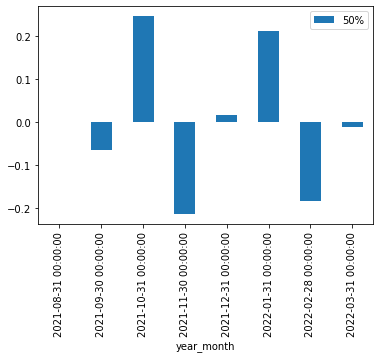

In [26]:
rev_change_bm[['50%']].plot(kind = 'bar')

In [27]:
rev_change_bm_with_weight = rev_change_bm[['year_month','50%']]
rev_change_bm_with_weight['weight'] = [0.44,0.52,0.6,0.68,0.76,0.84,0.92,1]
rev_change_bm_with_weight.columns = ['year_month','rev_change_bm','rev_change_weight']
rev_change_bm_with_weight = rev_change_bm_with_weight.reset_index(drop = True)
rev_change_bm_with_weight

,year_month,rev_change_bm,rev_change_weight
0,2021-08-31,NaN,0.44
1,2021-09-30,-0.064644,0.52
2,2021-10-31,0.246268,0.60
3,2021-11-30,-0.212712,0.68
4,2021-12-31,0.016038,0.76
5,2022-01-31,0.212624,0.84
6,2022-02-28,-0.183474,0.92
7,2022-03-31,-0.010967,1.00


In [28]:

blaze_gm_data_long_with_rev  = pd.merge(blaze_gm_data_long,rev_change_bm_with_weight,on=['year_month'], how='inner')
blaze_gm_data_long_with_rev['rev_change_var'] = blaze_gm_data_long_with_rev['rev_change'] - blaze_gm_data_long_with_rev['rev_change_bm']
blaze_gm_data_long_with_rev['rev_change_points'] = [gmv_change_variance_point_mapping(n) for n in blaze_gm_data_long_with_rev['rev_change_var']]
blaze_gm_data_long_with_rev['rev_change_total'] = blaze_gm_data_long_with_rev['rev_change_points'] * blaze_gm_data_long_with_rev['rev_change_weight']



In [29]:
blaze_gm_data_long_with_rev.head()

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total
0,2021-10-31,60a2e7b9b3d6203ac8fea106,60a2e7b9b3d6203ac8fea0ec,2101.50,NaN,1015.00,1086.50,0.517012,6,1015.00,0.517012,0.517012,0.517012,NaN,0.246268,0.6,NaN,NaN,NaN
1,2021-10-31,6138184c5498501d77622c27,60edb16f8d68a874d1592862,970190.71,123599.29,453494.47,516696.24,0.532572,7,511292.48,0.532474,0.532474,0.532474,6.849484,0.246268,0.6,6.603217,NaN,NaN
2,2021-10-31,6000fe33807ba708d56041fd,6000fe33807ba708d56041e5,4222.83,5457.71,5364.83,-1142.00,-0.270435,7,16037.11,0.082721,0.082721,0.082721,-0.226263,0.246268,0.6,-0.472531,-5.0,-3.0
3,2021-10-31,6132533ac57eb479d9a85663,6132533ac57eb479d9a8564a,718.05,500.00,433.50,284.55,0.396282,7,633.50,0.498141,0.498141,0.498141,0.436100,0.246268,0.6,0.189832,10.0,6.0
4,2021-10-31,5ca5725ee8379e080ae7cb62,5ca5725ee8379e080ae7cb4b,57251.67,50337.47,30609.49,26642.18,0.465352,8,82994.33,0.490825,0.490825,0.490825,0.137357,0.246268,0.6,-0.108911,-5.0,-3.0


In [30]:
#blaze_gm_data_long_with_rev[blaze_gm_data_long_with_rev['shopid'] == '5f3df0a5ef56f908dd5b372c']

# inventory

In [31]:
blaze_inv_data = pd.read_sql_query("""
with base as (
    select *,
    last_day(date) year_month,
    current_quantity * unit_cost total_value
    from blaze_data.inventory
    where  lower(product_category) not like '%sample%'
    and lower(product_category) not like '%display%'
    and lower(product_category) not like '%promo%'
    and lower(product_category) not like '%test%'
    -- EXCLUDE SMALL COGS
    and unit_cost > 0.01
    and current_quantity > 0
    and current_quantity < 1000
    and date in ('2021-08-29','2021-09-26','2021-10-31','2021-11-28','2021-12-26','2022-01-30','2022-02-27','2022-03-27','2022-04-03')
)

select
year_month,
shop_id shopid,
company_id companyid,
sum(total_value) inventory
from base
group by 1,2,3
order by 2,3,1


""",engine)

In [32]:
blaze_inv_data['shopid'].nunique()

558

In [33]:
#blaze_inv_data.groupby(['year_month'])['inventory'].describe().reset_index()

In [34]:
set(blaze_gm_data['shopid']) - set(blaze_inv_data['shopid'])

{'61415d73ef0869553cee8fec'}

# joined

In [35]:
data_joined = pd.merge(blaze_gm_data_long_with_rev,blaze_inv_data,on=['year_month','shopid','companyid'], how='inner')



In [36]:
data_joined['inventory_turnover'] = data_joined['sum_cogs_3m'] / data_joined['inventory'] * 4
data_joined['year_month'] = pd.to_datetime(data_joined['year_month'])

In [37]:
data_joined[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2021-08-31,203
2021-09-30,211
2021-10-31,225
2021-11-30,227
2021-12-31,227
2022-01-31,226
2022-02-28,222
2022-03-31,220


In [38]:
data_joined[data_joined['year_month'] >= '2021-10-31'].groupby(['year_month'])['inventory_turnover'].describe().reset_index()

,year_month,count,mean,std,min,25%,50%,75%,max
0,2021-10-31,225.0,9.394027,7.411256,0.010618,3.792546,7.848720,13.166624,49.260990
1,2021-11-30,227.0,12.578754,21.689517,0.007532,4.228776,7.931777,12.985238,247.326994
2,2021-12-31,227.0,10.386300,8.257513,0.004636,4.748882,8.900335,13.659940,55.747979
3,2022-01-31,226.0,9.204546,7.055932,0.003644,4.417127,7.862326,11.500967,45.418012
4,2022-02-28,222.0,13.400520,16.308517,0.003362,4.702113,9.127195,14.394002,134.682635
5,2022-03-31,220.0,9.518760,9.688187,0.003644,4.712822,8.104370,11.609382,116.302405


In [39]:
round(data_joined['inventory_turnover'].quantile(0.95),2)

25.8

# UW

In [40]:
recent = data_joined[data_joined['year_month'] == '2022-03-31']
recent = recent.reset_index(drop = True)

In [41]:
recent[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2022-03-31,220


## gm % score

In [42]:
def get_gm_perc_scores(threshold,gm_3,gm_6,gm_all):
    # 3m score
    if gm_3 <= threshold[0][0]:
        score_3m = -2
    elif threshold[0][0] < gm_3 <= threshold[0][1]:
        score_3m = 0
    elif threshold[0][1] < gm_3 <= threshold[0][2]:
        score_3m = 5
    elif threshold[0][2] < gm_3 <= threshold[0][3]:
        score_3m = 5
    else:
        score_3m = 0
    # 6m score
    if gm_6 <= threshold[1][0]:
        score_6m = -2
    elif threshold[1][0] < gm_6 <= threshold[1][1]:
        score_6m = 0
    elif threshold[1][1] < gm_6 <= threshold[1][2]:
        score_6m = 5
    elif threshold[1][2] < gm_6 <= threshold[1][3]:
        score_6m = 5
    else:
        score_6m = 0
    # all time score
    if gm_all <= threshold[2][0]:
        score_all = -2
    elif threshold[2][0] < gm_all <= threshold[2][1]:
        score_all = 0
    elif threshold[2][1] < gm_all <= threshold[2][2]:
        score_all = 5
    elif threshold[2][2] < gm_all <= threshold[2][3]:
        score_all = 5
    else:
        score_all = 0
    return score_3m,score_6m,score_all
    

In [ ]:
gm_threshold = [[0.47,0.53,0.59,0.7],[0.47,0.53,0.59,0.7],[0.47,0.53,0.59,0.7]]

In [ ]:
gm_threshold = [[0.46,0.52,0.58,0.7],[0.46,0.52,0.58,0.7],[0.46,0.52,0.58,0.7]]

In [ ]:
gm_threshold = [[0.45,0.51,0.57,0.7],[0.45,0.51,0.57,0.7],[0.45,0.51,0.57,0.7]]

In [43]:
gm_threshold = [[0.44,0.50,0.56,0.7],[0.44,0.50,0.56,0.7],[0.44,0.50,0.56,0.7]]

In [44]:
gm_score_data = recent.apply(lambda row: get_gm_perc_scores(gm_threshold,row['avg_margin_3m'],row['avg_margin_6m'],row['avg_margin_all']),axis = 1)
recent_with_gm = pd.concat([recent, pd.DataFrame([list(y) for y in gm_score_data.values], columns = ['gm_3m_score', 'gm_6m_score','gm_all_score'])],axis=1)



## inventory turnover score

In [45]:
recent_with_gm['turnover_score'] = [10 if (recent_with_gm['inventory_turnover'][i] >= 6 and recent_with_gm['inventory_turnover'][i] <= 26) else 0 for i in range(len(recent_with_gm))]



In [46]:
recent_with_gm.head()

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory,inventory_turnover,gm_3m_score,gm_6m_score,gm_all_score,turnover_score
0,2022-03-31,60a2e7b9b3d6203ac8fea106,60a2e7b9b3d6203ac8fea0ec,4462.71,7050.10,1842.52,2620.19,0.587130,6,7426.97,0.575057,0.552158,0.552158,-0.367000,-0.010967,1.0,-0.356034,-5.0,-5.0,23035.590000,1.289651,5,5,5,0
1,2022-03-31,6138184c5498501d77622c27,60edb16f8d68a874d1592862,1023003.85,1013148.43,464120.10,558883.75,0.546316,7,1465263.27,0.544555,0.541512,0.540207,0.009728,-0.010967,1.0,0.020694,5.0,5.0,655725.330369,8.938275,5,5,5,10
2,2022-03-31,6132533ac57eb479d9a85663,6132533ac57eb479d9a8564a,29531.42,26192.57,15409.49,14121.93,0.478200,7,50632.65,0.456084,0.440073,0.462919,0.127473,-0.010967,1.0,0.138440,10.0,10.0,73069.550000,2.771751,0,0,0,0
3,2022-03-31,5ca5725ee8379e080ae7cb62,5ca5725ee8379e080ae7cb4b,38317.19,44253.55,13216.01,25101.18,0.655089,8,49836.55,0.640451,0.566919,0.551080,-0.134144,-0.010967,1.0,-0.123177,-5.0,-5.0,20277.921667,9.830702,5,5,5,10
4,2022-03-31,5e336a31e0faca07f4739f38,5e336a31e0faca07f4739f1f,8168.10,9392.09,1322.72,6845.38,0.838063,8,4545.29,0.842794,0.882893,0.851887,-0.130321,-0.010967,1.0,-0.119355,-5.0,-5.0,6539.700000,2.780121,0,0,0,0


## rev change score

In [47]:
rev_change_score = blaze_gm_data_long_with_rev[['shopid','rev_change_total']].groupby('shopid').sum().reset_index()

In [48]:
rev_change_score['rev_change_score'] = [max(min(round(rev_change_score['rev_change_total'][i],2),10),-10) for i in range(len(rev_change_score))]
rev_change_score.sort_values(by = 'rev_change_total')


,shopid,rev_change_total,rev_change_score
155,5ff3a7f37b594108d041cb95,-26.6,-10.0
149,5fcff3a874329008ef2b4112,-20.2,-10.0
14,5ba96aac00635e08245eb7c7,-19.8,-10.0
130,5f77c6ead2fbea08c8d15a22,-18.5,-10.0
123,5f18c6e85c031a08e19861c2,-17.7,-10.0
...,...,...,...
139,5f99beff00fecc08ddc55c60,39.0,10.0
152,5fd90ebbd68f6608d3f9ed29,40.0,10.0
216,611df4df750db64ca4f656b5,42.0,10.0
137,5f92f1adf2816908d0491850,42.2,10.0


## gm $ score

In [49]:
gm_dollar_score = blaze_gm_data_long_with_rev[['shopid','profit_pre_tax_post_discount']].groupby('shopid').mean().reset_index()

In [50]:
gm_dollar_score['gm_dollar_score'] = [15 if gm_dollar_score['profit_pre_tax_post_discount'][i] >= 200000 else 0 for i in range(len(rev_change_score))]



In [51]:
recent_with_gm_and_rev_change = pd.merge(recent_with_gm,rev_change_score[['shopid','rev_change_score']],on=['shopid'], how='inner')
recent_with_gm_and_rev_change

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory,inventory_turnover,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score
0,2022-03-31,60a2e7b9b3d6203ac8fea106,60a2e7b9b3d6203ac8fea0ec,4462.71,7050.10,1842.52,2620.19,0.587130,6,7426.97,0.575057,0.552158,0.552158,-0.367000,-0.010967,1.0,-0.356034,-5.0,-5.0,23035.590000,1.289651,5,5,5,0,0.0
1,2022-03-31,6138184c5498501d77622c27,60edb16f8d68a874d1592862,1023003.85,1013148.43,464120.10,558883.75,0.546316,7,1465263.27,0.544555,0.541512,0.540207,0.009728,-0.010967,1.0,0.020694,5.0,5.0,655725.330369,8.938275,5,5,5,10,10.0
2,2022-03-31,6132533ac57eb479d9a85663,6132533ac57eb479d9a8564a,29531.42,26192.57,15409.49,14121.93,0.478200,7,50632.65,0.456084,0.440073,0.462919,0.127473,-0.010967,1.0,0.138440,10.0,10.0,73069.550000,2.771751,0,0,0,0,10.0
3,2022-03-31,5ca5725ee8379e080ae7cb62,5ca5725ee8379e080ae7cb4b,38317.19,44253.55,13216.01,25101.18,0.655089,8,49836.55,0.640451,0.566919,0.551080,-0.134144,-0.010967,1.0,-0.123177,-5.0,-5.0,20277.921667,9.830702,5,5,5,10,-1.2
4,2022-03-31,5e336a31e0faca07f4739f38,5e336a31e0faca07f4739f1f,8168.10,9392.09,1322.72,6845.38,0.838063,8,4545.29,0.842794,0.882893,0.851887,-0.130321,-0.010967,1.0,-0.119355,-5.0,-5.0,6539.700000,2.780121,0,0,0,0,-8.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,2022-03-31,5e359ab21742520837c6502c,5e359ab21742520837c65014,927614.01,922347.53,333838.53,593775.48,0.640111,8,1059422.19,0.648589,0.615847,0.605179,0.005710,-0.010967,1.0,0.016677,5.0,5.0,629251.283333,6.734494,5,5,5,10,10.0
216,2022-03-31,5ea1db94e0faca07e12ca5f3,5e97c9bbc6641308cf7d31d9,333073.84,334999.23,177434.20,155639.64,0.467283,8,536979.43,0.504668,0.535500,0.539598,-0.005747,-0.010967,1.0,0.005219,5.0,5.0,269000.641667,7.984805,5,5,5,10,10.0
217,2022-03-31,5ee3fa266c853308d5d888f7,5ee3fa266c853308d5d888df,932079.73,903486.84,580183.22,351896.51,0.377539,8,1891650.97,0.359246,0.293224,0.277495,0.031647,-0.010967,1.0,0.042614,5.0,5.0,524421.203333,14.428486,-2,-2,-2,10,10.0
218,2022-03-31,5ff8e7ff70b74f08c83f44f2,5ff8e7ff70b74f08c83f44da,301466.33,291524.08,159877.22,141589.11,0.469668,8,475878.00,0.467042,0.462048,0.465042,0.034104,-0.010967,1.0,0.045071,5.0,5.0,212812.645000,8.944544,0,0,0,10,10.0


In [52]:
final = pd.merge(recent_with_gm_and_rev_change,gm_dollar_score[['shopid','gm_dollar_score']],on=['shopid'], how='inner')



In [53]:
final['total_gm_perc_score'] = final['gm_3m_score'] + final['gm_6m_score'] + final['gm_all_score']
final['total_gm_score'] = [min(final['gm_dollar_score'][i]+final['total_gm_perc_score'][i],15) for i in range(len(final))]
final['total_score'] = final['total_gm_score'] + final['rev_change_score'] + final['turnover_score']
final['credit_limit'] = [round(min(final['sum_cogs_3m'][i],final['inventory'][i]),0) for i in range(len(final))]
                        



In [54]:
final['total_score'].describe()

count    220.000000
mean      21.531818
std       13.286141
min      -16.000000
25%       14.000000
50%       24.550000
75%       35.000000
max       35.000000
Name: total_score, dtype: float64

In [55]:
final['shopid'].nunique()

220

In [56]:
pass_list = final[final['total_score'] >= 24]

In [57]:
pass_list['shopid'].nunique()

112

In [58]:
pass_list_low_profit = pass_list[(pass_list['profit_pre_tax_post_discount'] < 25000)]

In [59]:
pass_list_low_profit

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory,inventory_turnover,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit
125,2022-03-31,5e2a1c1c1471bd0833a4358a,5e2a1c1c1471bd0833a43572,44455.59,44174.10,20258.23,24197.36,0.544304,8,63185.33,0.551775,0.552436,0.550614,0.006372,-0.010967,1.0,0.017339,5.0,5.0,24606.7650,10.271213,5,5,5,10,10.0,0,15,15,35.0,24607.0
137,2022-03-31,5dae02faed12be0829c3d21d,5c422367062bd807e98fc5dc,12616.15,7118.24,5150.58,7465.57,0.591747,8,11293.89,0.598544,0.600632,0.599464,0.772369,-0.010967,1.0,0.783336,NaN,NaN,4889.8500,9.238639,5,5,5,10,10.0,0,15,15,35.0,4890.0
169,2022-03-31,60cce6dd4dfc4451e9b20780,60cce6dd4dfc4451e9b20767,13444.89,13274.87,4762.94,8681.95,0.645743,8,16059.62,0.646960,0.651465,0.627451,0.012808,-0.010967,1.0,0.023774,5.0,5.0,27672.0975,2.321417,5,5,5,0,10.0,0,15,15,25.0,16060.0
192,2022-03-31,60f84b4964f1c0641efa6b41,5b6dc2ddf00be50842477f69,8087.41,6611.00,3574.98,4512.43,0.557957,8,13075.48,0.584440,0.595071,0.594971,0.223326,-0.010967,1.0,0.234293,10.0,10.0,18434.5700,2.837165,5,5,5,0,10.0,0,15,15,25.0,13075.0
206,2022-03-31,61048ae67b662c508d518425,61048ae67b662c508d51840b,20692.90,23394.43,9668.97,11023.93,0.532740,8,34363.18,0.528756,0.517464,0.535740,-0.115477,-0.010967,1.0,-0.104511,-5.0,-5.0,36756.2750,3.739572,5,5,5,0,9.4,0,15,15,24.4,34363.0


In [60]:
pass_list_low_limit = pass_list[(pass_list['credit_limit'] < 30000)]

In [61]:
pass_list_low_limit

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory,inventory_turnover,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit
7,2022-03-31,5e7b7fb91a3bbe09119b2fff,5e7b7fb91a3bbe09119b2fe7,98018.54,104218.63,38188.18,59830.36,0.610398,8,163463.69,0.580050,0.563105,0.558061,-0.059491,-0.010967,1.0,-0.048524,0.0,0.0,27541.736667,23.740506,5,5,5,10,-0.0,0,15,15,25.0,27542.0
75,2022-03-31,5d5b9072a3f8d3081dc7545a,5d5b9072a3f8d3081dc75443,116274.32,115566.35,45703.20,70571.12,0.606936,8,134471.49,0.637740,0.588558,0.583121,0.006126,-0.010967,1.0,0.017093,5.0,5.0,15285.876667,35.188427,5,5,5,0,10.0,0,15,15,25.0,15286.0
125,2022-03-31,5e2a1c1c1471bd0833a4358a,5e2a1c1c1471bd0833a43572,44455.59,44174.10,20258.23,24197.36,0.544304,8,63185.33,0.551775,0.552436,0.550614,0.006372,-0.010967,1.0,0.017339,5.0,5.0,24606.765000,10.271213,5,5,5,10,10.0,0,15,15,35.0,24607.0
137,2022-03-31,5dae02faed12be0829c3d21d,5c422367062bd807e98fc5dc,12616.15,7118.24,5150.58,7465.57,0.591747,8,11293.89,0.598544,0.600632,0.599464,0.772369,-0.010967,1.0,0.783336,NaN,NaN,4889.850000,9.238639,5,5,5,10,10.0,0,15,15,35.0,4890.0
169,2022-03-31,60cce6dd4dfc4451e9b20780,60cce6dd4dfc4451e9b20767,13444.89,13274.87,4762.94,8681.95,0.645743,8,16059.62,0.646960,0.651465,0.627451,0.012808,-0.010967,1.0,0.023774,5.0,5.0,27672.097500,2.321417,5,5,5,0,10.0,0,15,15,25.0,16060.0
191,2022-03-31,6095c065920e5112d6303e56,6095c065920e5112d6303e3d,139825.25,171256.12,69867.49,69957.76,0.500323,8,222870.21,0.502034,0.505845,0.504496,-0.183531,-0.010967,1.0,-0.172565,-5.0,-5.0,22746.200000,39.192517,5,5,5,0,10.0,0,15,15,25.0,22746.0
192,2022-03-31,60f84b4964f1c0641efa6b41,5b6dc2ddf00be50842477f69,8087.41,6611.00,3574.98,4512.43,0.557957,8,13075.48,0.584440,0.595071,0.594971,0.223326,-0.010967,1.0,0.234293,10.0,10.0,18434.570000,2.837165,5,5,5,0,10.0,0,15,15,25.0,13075.0


In [62]:
set(pass_list_low_profit['shopid']).union(pass_list_low_limit['shopid'])



{'5d5b9072a3f8d3081dc7545a',
 '5dae02faed12be0829c3d21d',
 '5e2a1c1c1471bd0833a4358a',
 '5e7b7fb91a3bbe09119b2fff',
 '6095c065920e5112d6303e56',
 '60cce6dd4dfc4451e9b20780',
 '60f84b4964f1c0641efa6b41',
 '61048ae67b662c508d518425'}

In [63]:
final_pass = pass_list[(pass_list['profit_pre_tax_post_discount'] >= 25000) & (pass_list['credit_limit'] >= 30000)]
final_pass = final_pass.reset_index(drop = True)

In [64]:
final_pass

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory,inventory_turnover,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit
0,2022-03-31,6138184c5498501d77622c27,60edb16f8d68a874d1592862,1023003.85,1013148.43,464120.10,558883.75,0.546316,7,1465263.27,0.544555,0.541512,0.540207,0.009728,-0.010967,1.0,0.020694,5.0,5.0,655725.330369,8.938275,5,5,5,10,10.0,15,15,15,35.0,655725.0
1,2022-03-31,5c422367062bd807e98fc5f3,5c422367062bd807e98fc5dc,60607.95,40805.15,25592.83,35015.12,0.577731,8,66792.47,0.590716,0.592514,0.603302,0.485301,-0.010967,1.0,0.496268,10.0,10.0,34747.292500,7.688941,5,5,5,10,8.5,0,15,15,33.5,34747.0
2,2022-03-31,5e8235b279a9cf08cb849efc,5cc3a08d5fecd30808b416cb,437265.29,458014.07,230013.62,207251.67,0.473972,8,783707.75,0.466715,0.463332,0.461134,-0.045302,-0.010967,1.0,-0.034335,0.0,0.0,168489.391667,18.605510,0,0,0,10,10.0,15,0,15,35.0,168489.0
3,2022-03-31,605a1db5ed256d08dde9cbea,5ebb25915a7c1308eda55413,488542.13,511525.91,191337.07,297205.06,0.608351,8,612200.84,0.604922,0.602169,0.599081,-0.044932,-0.010967,1.0,-0.033965,0.0,0.0,219761.506667,11.143004,5,5,5,10,10.0,15,15,15,35.0,219762.0
4,2022-03-31,60d264a3792f432a92a3904d,60d264a3792f432a92a39034,506863.68,483665.93,279975.82,226887.86,0.447631,8,854341.27,0.449116,0.443307,0.440685,0.047962,-0.010967,1.0,0.058929,10.0,10.0,266429.628333,12.826520,0,0,0,10,10.0,15,0,15,35.0,266430.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,2022-03-31,5d269b0a75941307f4f7823a,5d269b0a75941307f4f78223,390138.43,397079.87,174674.97,215463.46,0.552274,8,570196.73,0.549857,0.545848,0.543921,-0.017481,-0.010967,1.0,-0.006514,0.0,0.0,250469.853000,9.106034,5,5,5,10,10.0,15,15,15,35.0,250470.0
100,2022-03-31,616a37dcd771ce141b7d4068,60edb16f8d68a874d1592862,1879084.95,1854339.83,854688.34,1024396.61,0.545157,6,2768836.89,0.539251,0.521355,0.521355,0.013344,-0.010967,1.0,0.024311,5.0,5.0,815216.965530,13.585767,5,5,5,10,10.0,15,15,15,35.0,815217.0
101,2022-03-31,5e359ab21742520837c6502c,5e359ab21742520837c65014,927614.01,922347.53,333838.53,593775.48,0.640111,8,1059422.19,0.648589,0.615847,0.605179,0.005710,-0.010967,1.0,0.016677,5.0,5.0,629251.283333,6.734494,5,5,5,10,10.0,15,15,15,35.0,629251.0
102,2022-03-31,5ea1db94e0faca07e12ca5f3,5e97c9bbc6641308cf7d31d9,333073.84,334999.23,177434.20,155639.64,0.467283,8,536979.43,0.504668,0.535500,0.539598,-0.005747,-0.010967,1.0,0.005219,5.0,5.0,269000.641667,7.984805,5,5,5,10,10.0,15,15,15,35.0,269001.0


In [65]:
final_pass['credit_limit_final'] = [min(max(final_pass['credit_limit'][i],50000),250000) for i in range(len(final_pass))]

In [67]:
final_pass['credit_limit'].describe()

count       104.000000
mean     235672.028846
std      197251.912698
min       34747.000000
25%       89464.500000
50%      175673.000000
75%      302841.500000
max      994897.000000
Name: credit_limit, dtype: float64

In [68]:
final_pass['credit_limit'].sum()

24509891.0

In [69]:
final_pass['credit_limit_final'].describe()

count       104.000000
mean     167624.221154
std       78062.669115
min       50000.000000
25%       89464.500000
50%      175673.000000
75%      250000.000000
max      250000.000000
Name: credit_limit_final, dtype: float64

In [70]:
final_pass['credit_limit_final'].sum()

17432919.0

In [82]:
final_pass.shape[0]/335

0.31044776119402984

In [79]:
final_pass.shape[0] / blaze_gm_data.shape[0]

0.05007221954742417

In [81]:
blaze_gm_data['shopid'].nunique()

335

In [84]:
final_pass['rev_pre_tax_post_discount'].describe()

count    1.040000e+02
mean     4.113370e+05
std      3.594478e+05
min      4.754941e+04
25%      1.715620e+05
50%      3.118911e+05
75%      5.366096e+05
max      2.224791e+06
Name: rev_pre_tax_post_discount, dtype: float64

In [83]:
final_pass

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory,inventory_turnover,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit,credit_limit_final
0,2022-03-31,6138184c5498501d77622c27,60edb16f8d68a874d1592862,1023003.85,1013148.43,464120.10,558883.75,0.546316,7,1465263.27,0.544555,0.541512,0.540207,0.009728,-0.010967,1.0,0.020694,5.0,5.0,655725.330369,8.938275,5,5,5,10,10.0,15,15,15,35.0,655725.0,250000.0
1,2022-03-31,5c422367062bd807e98fc5f3,5c422367062bd807e98fc5dc,60607.95,40805.15,25592.83,35015.12,0.577731,8,66792.47,0.590716,0.592514,0.603302,0.485301,-0.010967,1.0,0.496268,10.0,10.0,34747.292500,7.688941,5,5,5,10,8.5,0,15,15,33.5,34747.0,50000.0
2,2022-03-31,5e8235b279a9cf08cb849efc,5cc3a08d5fecd30808b416cb,437265.29,458014.07,230013.62,207251.67,0.473972,8,783707.75,0.466715,0.463332,0.461134,-0.045302,-0.010967,1.0,-0.034335,0.0,0.0,168489.391667,18.605510,0,0,0,10,10.0,15,0,15,35.0,168489.0,168489.0
3,2022-03-31,605a1db5ed256d08dde9cbea,5ebb25915a7c1308eda55413,488542.13,511525.91,191337.07,297205.06,0.608351,8,612200.84,0.604922,0.602169,0.599081,-0.044932,-0.010967,1.0,-0.033965,0.0,0.0,219761.506667,11.143004,5,5,5,10,10.0,15,15,15,35.0,219762.0,219762.0
4,2022-03-31,60d264a3792f432a92a3904d,60d264a3792f432a92a39034,506863.68,483665.93,279975.82,226887.86,0.447631,8,854341.27,0.449116,0.443307,0.440685,0.047962,-0.010967,1.0,0.058929,10.0,10.0,266429.628333,12.826520,0,0,0,10,10.0,15,0,15,35.0,266430.0,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,2022-03-31,5d269b0a75941307f4f7823a,5d269b0a75941307f4f78223,390138.43,397079.87,174674.97,215463.46,0.552274,8,570196.73,0.549857,0.545848,0.543921,-0.017481,-0.010967,1.0,-0.006514,0.0,0.0,250469.853000,9.106034,5,5,5,10,10.0,15,15,15,35.0,250470.0,250000.0
100,2022-03-31,616a37dcd771ce141b7d4068,60edb16f8d68a874d1592862,1879084.95,1854339.83,854688.34,1024396.61,0.545157,6,2768836.89,0.539251,0.521355,0.521355,0.013344,-0.010967,1.0,0.024311,5.0,5.0,815216.965530,13.585767,5,5,5,10,10.0,15,15,15,35.0,815217.0,250000.0
101,2022-03-31,5e359ab21742520837c6502c,5e359ab21742520837c65014,927614.01,922347.53,333838.53,593775.48,0.640111,8,1059422.19,0.648589,0.615847,0.605179,0.005710,-0.010967,1.0,0.016677,5.0,5.0,629251.283333,6.734494,5,5,5,10,10.0,15,15,15,35.0,629251.0,250000.0
102,2022-03-31,5ea1db94e0faca07e12ca5f3,5e97c9bbc6641308cf7d31d9,333073.84,334999.23,177434.20,155639.64,0.467283,8,536979.43,0.504668,0.535500,0.539598,-0.005747,-0.010967,1.0,0.005219,5.0,5.0,269000.641667,7.984805,5,5,5,10,10.0,15,15,15,35.0,269001.0,250000.0


In [72]:
#final_pass.to_csv('final_pass_0421_1.csv')

# wow rev change

In [ ]:
#you can also query like this
wow = pd.read_sql_query("""
with base as
(
   select
      *,
      --last_day(week_start) year_month,
      retail_value / quantity_sold per_unit_price,
      cogs / quantity_sold per_unit_cost,
      sales.retail_value - sales.total_discount + sales.total_tax sales_post_tax_post_discount,
      sales.retail_value - sales.total_discount sales_pre_tax_post_discount,
      sales.retail_value sales_pre_tax_pre_discount,
   from
      blaze_data.sales sales
      -- EXCLUDE SAMPLES,DISPLAY,PROMO and test
   where
      lower(product_category) not like '%sample%'
      and lower(product_category) not like '%display%'
      and lower(product_category) not like '%promo%'
     and lower(product_category) not like '%test%'
)


,
monthly_location_rev_and_cogs as
(
   select
      week_start,
      week_end,
      shopid,
      companyid,
      sum(sales_post_tax_post_discount) rev_post_tax_post_discount,
      sum(sales_pre_tax_post_discount) rev_pre_tax_post_discount,
      sum(sales_pre_tax_pre_discount) rev_pre_tax_pre_discount,
      sum(cogs) cogs
   from
      base
      -- EXCLUDE low COGS items
   where
      cogs > 1
      -- EXCLUDE high cost, high price items
      and per_unit_price <= 500
      and per_unit_cost <= 500
   group by
      3,
      4,
      1,
      2
   order by
      3,
      4,
      1,
      2
)
,
monthly_location_rev_and_cogs_and_profit as
(
   select
      week_start,
      week_end,
      shopid,
      companyid,
      -- rev and cogs
      rev_post_tax_post_discount,
      rev_pre_tax_post_discount,
      rev_pre_tax_pre_discount,
      cogs,
      -- profit
      rev_post_tax_post_discount - cogs profit_post_tax_post_discount,
      rev_pre_tax_post_discount - cogs profit_pre_tax_post_discount,
      rev_pre_tax_pre_discount - cogs profit_pre_tax_pre_discount,
   from
      monthly_location_rev_and_cogs
)
,
monthly_location_rev_and_cogs_and_profit_and_margin as
(
   select
      week_start,
      week_end,
      shopid,
      companyid,
      -- rev and cogs
      rev_post_tax_post_discount,
      rev_pre_tax_post_discount,
      rev_pre_tax_pre_discount,
      cogs,
      -- profit
      profit_post_tax_post_discount,
      profit_pre_tax_post_discount,
      profit_pre_tax_pre_discount,
      -- margin
      profit_post_tax_post_discount / nullif(rev_post_tax_post_discount, 0) margin_post_tax_post_discount,
      profit_pre_tax_post_discount / nullif(rev_pre_tax_post_discount, 0) margin_pre_tax_post_discount,
      profit_pre_tax_pre_discount / nullif(rev_pre_tax_pre_discount, 0) margin_pre_tax_pre_discount
   from
      monthly_location_rev_and_cogs_and_profit
)
,
monthly_gm_analysis as
(
   select
      week_start,
      week_end,
      shopid,
      companyid,
      -- CHOOSE TO USE PRE TAX POST DISCOUNT
      rev_pre_tax_post_discount,
      lag(rev_pre_tax_post_discount) over (partition by shopid order by week_start) lag_rev_pre_tax_post_discount,
      cogs,
      profit_pre_tax_post_discount,
      margin_pre_tax_post_discount,
      count(distinct week_start) over (partition by shopid ) month_available
    --  sum(cogs) over (partition by shopid order by week_start rows between 2 preceding and current row ) sum_cogs_3m,
     -- avg(margin_pre_tax_post_discount) over (partition by shopid order by week_start rows between 2 preceding and current row ) avg_margin_3m,
     -- avg(margin_pre_tax_post_discount) over (partition by shopid order by week_start rows between 5 preceding and current row ) avg_margin_6m,
      --avg(margin_pre_tax_post_discount) over (partition by shopid order by week_start ) avg_margin_all
   from
      monthly_location_rev_and_cogs_and_profit_and_margin
)
select
   *,
   (
      rev_pre_tax_post_discount - lag_rev_pre_tax_post_discount
   )
   / nullif(lag_rev_pre_tax_post_discount, 0) rev_change
from
   monthly_gm_analysis
where shopid not in ("5e50449d6c0a910843356fa3",
"5e666af1aa809b085a98a646",
"56cf846ee38179985229e59e",
"5e6d0948b987950831b5092c",
"5ab806d6c182bb072e0b0e01",
"617b7da0e5cb65322b32781a",
"56cf84e4e38179985229e59f",
"5ee7c6a938fa9a08c8b7939c",
"5eebecd661ea0b08cdbcc386",
"56cf855ce38179985229e5a0",
"5ef12ad7bb5e7a08c5b3f4f3",
"5f1108355ae12008f4fef76e",
"5f123a5d12497908d2888dde",
"5f2309d579373608c93e6742",
"5f341ed02fdd5608e0821b45",
"5f8870200260fe08fe708db5",
"5f8870200260fe08fe708db6",
"5fac6a0b0643cc08efd1d327",
"56cf855ce38179985229e5a1",
"5d238c1955be2e07f5ee66e5",
"57b35a5d920f401e40146301",
"603d1a9eb9d7dc08cca27203",
"603d1a9eb9d7dc08cca27204",
"6046544f61e17808cff96fdb",
"6046544f61e17808cff96fdc",
"57b35aa8920f401e40146334",
"57b6b145920f4045cbe5fe81",
"6059219abe32aa08fa3a11dc",
"57b6b36a920f4046337f2618",
"58a7433f819d9e6ebd427617",
"60c0ffd6331cab296f02f49a",
"610c0a0d381ba0747c981ce9",
"611c0c98127cdd740cff94db",
"5a43f72b819d9e3ef9373675",
"611c0cc403d2e97dc2c159b0",
"5e6d0ac5b987950831b513e3",
"5a4563f1819d9e4ae6207e06",
"611c0ce7649819050ed4906b",
"611c0d02f572ec7882d64eea",
"611c0d26d5f1e86542fe3b8b",
"61672305b5e382719c7e4c2a",
"616dee0e4497e822dae13b21",
"616e5b13dd10fe4d3f34fd05",
"616e5b13dd10fe4d3f34fd06",
"619834e921c8017e23135674",
"5ab2d1a5819d9e21137cec3c",
"61bb746b82fddc50e058d711",
"61c3be757511d81170a29d51",
"61d49080eec1b51a3e33dc39",
"61d8912bdd71d40c2b68c5b3",
"61ba4efb9536472be6a8baa9",
"61d895fb3efbfb6da5210ae3",
"61d8aaf527205210191d7a1e",
"61e72d51073c4a79cfeccb62",
"61fdab9eae59d05c49422c3a",
"6202bd1c15425361f688aabf",
"6202bd1c15425361f688aac0",
"5b9f8e1db93307080d35b85f",
"5c2c250eabe12808989ac2f7",
"58be5603c182bb1f9bcd2ad5",
"5c8be64665a6a40808118621",
"606761051436a608e166db19",
"5ce2eb562d4dcf07fb7d0c5f",
"6176fa9eda707b1faba5f717",
"5b517867485da70830fcc04e",
"5b9f841a17b6e00812fe71f3",
"5da023586d8ce1082b9c91bd",
"5bbce3db420c21083300e410",
"5d238c1955be2e07f5ee66e4",
"5b209459062bd807b142a1f6",
"5cb1a5839fbb5f0818f6de55",
"5cda1adb183d6a0801347027",
"5be3903b79015e083194aa70",
"5d1ba174cdbd6d0803c99cfd",
"5a8a6eb8819d9e78641ab6ec",
"5db863825a04a2083b464083",
"5d8a7fb3a3274308311743d5",
"5d8a7fb3a3274308311743d6",
"5d9e425d52d15b0824a8a5d5",
"5dd6da52ce4015084c72e8db",
"5e07f51837cdd7082662f3c6",
"5e4d849981e3cd08326b6c14",
"5dfd2308fa462a086a8bfab8",
"5e0ee2710a7b7008346b06b4",
"5e4d849981e3cd08326b6c15",
"5dfd2308fa462a086a8bfab9",
"5e6d0adc12f2e208728f9369",
"5e6d0948b987950831b5092b",
"5ed589d96c0bf408dcc92d97",
"5eebecd761ea0b08cdbcc387",
"5ef12ad7bb5e7a08c5b3f4f2",
"5f63afd430bd7208ce1ab304",
"5f63afd430bd7208ce1ab305",
"5bf5ce54062bd807e436b473",
"5fac691a715f3808cd0aa82d",
"5d9d7fc27e2e46081e7e69f3",
"6034287d52503608c0b3ca48",
"5dfd40ea521ea90860c91848",
"6034287d52503608c0b3ca49",
"60636227ec491108d1c970d5",
"5a9a2274c182bb4ec00a72ca",
"60aea3bb1940943cecec2dbf",
"60a2f1610f75543c8e7dde50",
"5eb98f2d649a6508f87a6436",
"5e62a68447d90a086b8231c0",
"5e62a68447d90a086b8231c1",
"615b634cac08aa0a794158c4",
"60a2db8d0f75543c8e7d513b",
"60a2db8d0f75543c8e7d513c",
"60a4051e67406e7edad8ab88",
"60c0ff66082dcc61e42ad4a6",
"60c0ff66082dcc61e42ad4a7",
"6046c57057abe808d1f260fd",
"60636227ec491108d1c970d4",
"610abcaec3d09859f9b630d1",
"606cfaadba253e08c4189a63",
"607a321441cfa308f6e65b58",
"6197e31b21c8017e2310c10e",
"611d457db7c6f80914292394",
"610c0a0d381ba0747c981cea",
"610abcaec3d09859f9b630d2",
"611c0cb3a29e0f598f108a60",
"5fff453a81a63608d3a1a5b7",
"615237cc0937e52684b6c134",
"620b59c97852ca7a7dcc6f05",
"6196aa4deb62c87eba4014ad",
"619816781f88a1280f8a0c28",
"61d7b217a42c2f124d9b76b1",
"61cf4b452bc6657512b92d2a",
"61ebb060b04dc7510465f774",
"61eedaa0b882812f2f46a23d",
"61eedade6716dd2a2e0cfce5",
"5e6d0ae6e4a25a0834047467",
"5dc3315fe0faca07c6dfe849",
"5f7e17594445b008d2f63ebd",
"5f7f63053dbcad08cc9edbfb",
"5fff453a81a63608d3a1a5b8",
"603d5425a9ca7208f886d156",
"60e48dbbd5596d7c8a1d24dc",
"611c0d335901162ff90ef4dd",
"613f771aa96c863c00c1517d",
"6153b70fd343dc6230c4b67d",
"61699cdf032e1c1f920ec70f",
"61699cdf032e1c1f920ec710",
"61a7b4c6c8c7d85ea1846f14",
"61c390cfb863cb3baddb70f4",
"61d7b252ae999342ac05499e",
"61e6f857c5da34762f1c1fb5",
"61ebb00a335a531542342a32",
"620b59c97852ca7a7dcc6f04",
"6226640755810d3311e8ecd0")
""",engine)

In [ ]:
wow

In [ ]:
wow_bm = wow.groupby(['week_start','week_end'])['rev_change'].describe().reset_index()
wow_bm.index = pd.to_datetime(wow_bm['week_start'])
wow_bm

In [ ]:
wow_bm[['50%']].plot(kind= 'bar',figsize = (10,8))